<a href="https://colab.research.google.com/github/iliab1/TensorFlow_Projects/blob/main/CNN_cats_vs_dogs.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Import Libraries

In [ ]:
# Standard libraries
import os
import time
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import pandas as pd
import seaborn as sns
from sklearn.metrics import classification_report, confusion_matrix

# TensorFlow and Keras modules
import tensorflow as tf
from tensorflow import keras
from keras import layers, models
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import (
    Dense,
    MaxPooling2D,
    Dropout,
    Flatten,
    BatchNormalization,
    Conv2D,
    Input
)
from tensorflow import data as tf_data
from tensorflow.keras.preprocessing import image_dataset_from_directory
from tensorflow.keras.callbacks import (
    ReduceLROnPlateau,
    EarlyStopping,
    TensorBoard
)

# Prepare Data

## Load Dataset

In [ ]:
# Download kaggle cats and dogs dataset
!wget -P /content/cats_and_dogs https://download.microsoft.com/download/3/E/1/3E1C3F21-ECDB-4869-8368-6DEBA77B919F/kagglecatsanddogs_5340.zip
!unzip -q /content/cats_and_dogs/kagglecatsanddogs_5340.zip -d /content/cats_and_dogs/

--2024-09-19 21:52:02--  https://download.microsoft.com/download/3/E/1/3E1C3F21-ECDB-4869-8368-6DEBA77B919F/kagglecatsanddogs_5340.zip
Resolving download.microsoft.com (download.microsoft.com)... 23.196.50.17, 2600:1407:7400:1187::317f, 2600:1407:7400:1184::317f
Connecting to download.microsoft.com (download.microsoft.com)|23.196.50.17|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 824887076 (787M) [application/octet-stream]
Saving to: ‘/content/cats_and_dogs/kagglecatsanddogs_5340.zip.2’

kagglecatsanddogs_5 100%[===================>] 786.67M   234MB/s    in 3.5s    

2024-09-19 21:52:05 (227 MB/s) - ‘/content/cats_and_dogs/kagglecatsanddogs_5340.zip.2’ saved [824887076/824887076]

replace /content/cats_and_dogs/PetImages/Cat/0.jpg? [y]es, [n]o, [A]ll, [N]one, [r]ename: A
Y


## Remove corrupted images

In [ ]:
data_dir = '/content/cats_and_dogs/PetImages'

num_skipped = 0
for folder_name in ("Cat", "Dog"):
    folder_path = os.path.join(data_dir, folder_name)
    for fname in os.listdir(folder_path):
        fpath = os.path.join(folder_path, fname)
        try:
            fobj = open(fpath, "rb")
            is_jfif = b"JFIF" in fobj.peek(10)
        finally:
            fobj.close()

        if not is_jfif:
            num_skipped += 1
            # Delete corrupted image
            os.remove(fpath)

print(f"Deleted {num_skipped} images.")

Deleted 1590 images.


## Create dataset

In [ ]:
data_dir = '/content/cats_and_dogs/PetImages'
img_size = 180
batch_size = 128

ds = image_dataset_from_directory(
    data_dir,
    labels='inferred',
    label_mode = 'binary',
    batch_size=batch_size,
    image_size=(img_size, img_size),
    seed=42
)

Found 23410 files belonging to 2 classes.


In [ ]:
def get_dataset_partitions_tf(ds: tf.data.Dataset, ds_size, train_split=0.8, val_split=0.1, test_split=0.1, shuffle=True, shuffle_size=10000):
    assert (train_split + test_split + val_split) == 1

    if shuffle:
        ds = ds.shuffle(shuffle_size, seed=42)

    train_size = int(train_split * ds_size)
    val_size = int(val_split * ds_size)

    train_ds = ds.take(train_size)
    val_ds = ds.skip(train_size).take(val_size)
    test_ds = ds.skip(train_size).skip(val_size)

    return train_ds, val_ds, test_ds

train_dataset, validation_dataset, test_dataset = get_dataset_partitions_tf(ds, len(ds))

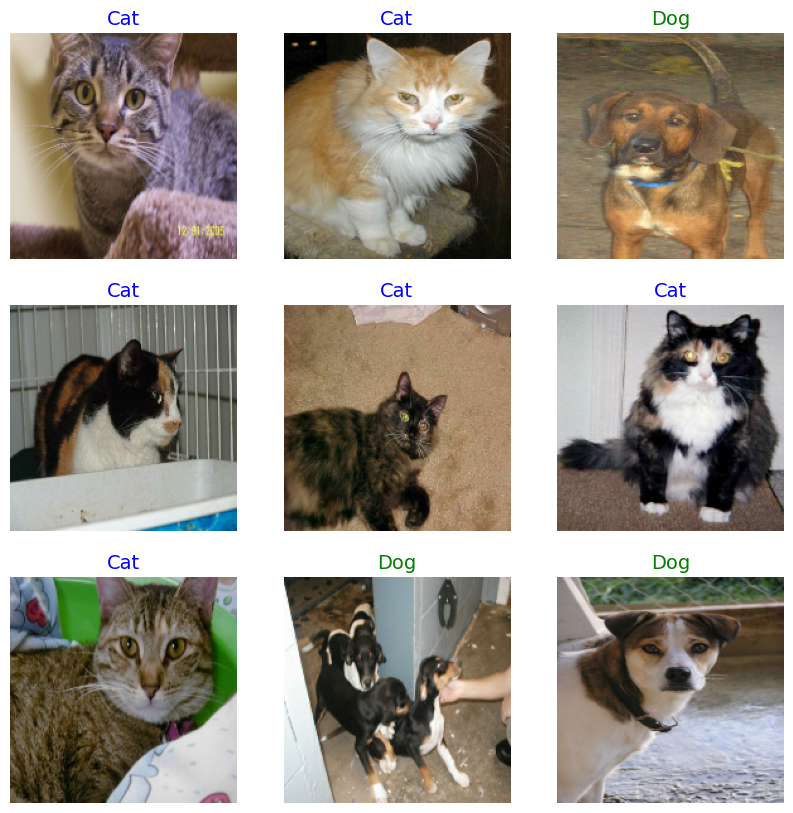

In [ ]:
plt.figure(figsize=(10, 10))
for images, labels in train_dataset.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(np.array(images[i]).astype("uint8"))
        if labels[i]:
            plt.title("Dog", fontsize=14, color="green")
        else:
            plt.title("Cat", fontsize=14, color="blue")
        plt.axis("off")
plt.show()

## Data augmentation

In [ ]:
data_augmentation_layers = [
    layers.RandomFlip("horizontal"),
    layers.RandomRotation(0.1),
]

def data_augmentation(images):
    for layer in data_augmentation_layers:
        images = layer(images)
    return images

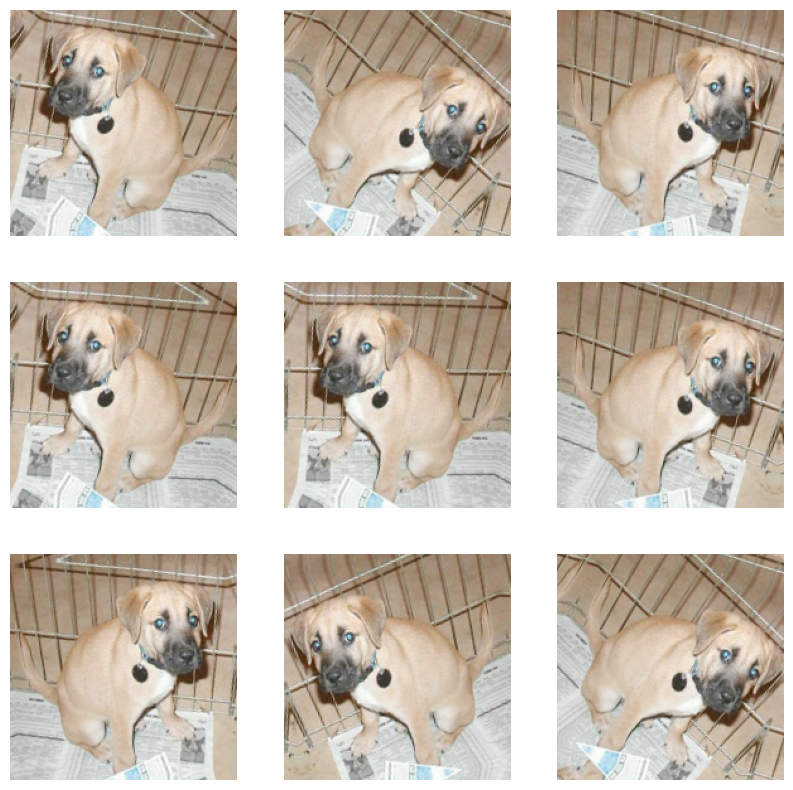

In [ ]:
plt.figure(figsize=(10, 10))
for images, _ in train_dataset.take(1):
    for i in range(9):
        augmented_images = data_augmentation(images)
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(np.array(augmented_images[0]).astype("uint8"))
        plt.axis("off")
plt.show()

In [ ]:
# Apply data_augmentation
train_dataset = train_dataset.map(
    lambda img, label: (data_augmentation(img), label),
    num_parallel_calls=tf_data.AUTOTUNE,
)

In [ ]:
train_dataset = train_dataset.prefetch(tf_data.AUTOTUNE)
validation_dataset = validation_dataset.prefetch(tf_data.AUTOTUNE)
test_dataset = test_dataset.prefetch(tf_data.AUTOTUNE)

# Train CNN model

## Define the model

In [ ]:
# Model definition
model = models.Sequential()
image_channel = 3
image_size = 180

# Input Layer
model.add(layers.Input(shape=(image_size, image_size, image_channel)))
model.add(layers.Rescaling(1.0 / 255))

# First Convolutional Layer with 128 filters
model.add(layers.Conv2D(128, 3, strides=2, padding="same"))
model.add(layers.BatchNormalization())
model.add(layers.Activation("relu"))

# First block with 256 filters
model.add(layers.SeparableConv2D(256, 3, padding="same"))
model.add(layers.BatchNormalization())
model.add(layers.Activation("relu"))
model.add(layers.SeparableConv2D(256, 3, padding="same"))
model.add(layers.BatchNormalization())
model.add(layers.MaxPooling2D(3, strides=2, padding="same"))

# Second block with 512 filters
model.add(layers.SeparableConv2D(512, 3, padding="same"))
model.add(layers.BatchNormalization())
model.add(layers.Activation("relu"))
model.add(layers.SeparableConv2D(512, 3, padding="same"))
model.add(layers.BatchNormalization())
model.add(layers.MaxPooling2D(3, strides=2, padding="same"))

# Third block with 728 filters
model.add(layers.SeparableConv2D(728, 3, padding="same"))
model.add(layers.BatchNormalization())
model.add(layers.Activation("relu"))
model.add(layers.SeparableConv2D(728, 3, padding="same"))
model.add(layers.BatchNormalization())
model.add(layers.MaxPooling2D(3, strides=2, padding="same"))

# Final block with 1024 filters
model.add(layers.SeparableConv2D(1024, 3, padding="same"))
model.add(layers.BatchNormalization())
model.add(layers.Activation("relu"))
model.add(layers.GlobalAveragePooling2D())

# Output layer with sigmoid activation func
model.add(layers.Dropout(0.25))
model.add(layers.Dense(1, activation='sigmoid'))

model.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ rescaling_2 (Rescaling)              │ (None, 180, 180, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 90, 90, 128)         │           3,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_16               │ (None, 90, 90, 128)         │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_10 (Activation)           │ (None, 90, 90, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ separable_conv2d_14                  │ (None, 90, 90, 256)         │          34,176 │
│ (SeparableConv2D)                    │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_17               │ (None, 90, 90, 256)         │           1,024 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_11 (Activation)           │ (None, 90, 90, 256)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ separable_conv2d_15                  │ (None, 90, 90, 256)         │          68,096 │
│ (SeparableConv2D)                    │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_18               │ (None, 90, 90, 256)         │           1,024 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_6 (MaxPooling2D)       │ (None, 45, 45, 256)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ separable_conv2d_16                  │ (None, 45, 45, 512)         │         133,888 │
│ (SeparableConv2D)                    │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_19               │ (None, 45, 45, 512)         │           2,048 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_12 (Activation)           │ (None, 45, 45, 512)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ separable_conv2d_17                  │ (None, 45, 45, 512)         │         267,264 │
│ (SeparableConv2D)                    │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_20               │ (None, 45, 45, 512)         │           2,048 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_7 (MaxPooling2D)       │ (None, 23, 23, 512)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ separable_conv2d_18                  │ (None, 23, 23, 728)         │         378,0

 Total params: 2,192,993 (8.37 MB)

 Trainable params: 2,184,705 (8.33 MB)

 Non-trainable params: 8,288 (32.38 KB)

## Train model

In [ ]:
# Specify callbacks
tensorboard = TensorBoard(log_dir=f'logs/model')

learning_rate_reduction = ReduceLROnPlateau(monitor='val_acc',
                                            patience=2,
                                            factor=0.5,
                                            min_lr = 0.00001,
                                            verbose = 1
)

early_stoping = EarlyStopping(monitor='val_loss',
                              patience= 3,
                              restore_best_weights=True,
                              verbose=0
)

In [ ]:
# Compile model
model.compile(optimizer='adam',
              loss=keras.losses.BinaryCrossentropy(from_logits=False),
              metrics=[keras.metrics.BinaryAccuracy(name="acc")]
)

In [ ]:
# Finally train CNN model
cat_n_dog = model.fit(train_dataset,
                      validation_data = validation_dataset,
                      epochs = 25,
                      callbacks=[early_stoping,learning_rate_reduction, tensorboard]
)

Epoch 1/25
146/146 ━━━━━━━━━━━━━━━━━━━━ 37s 147ms/step - acc: 0.6477 - loss: 0.6410 - val_acc: 0.5009 - val_loss: 0.6932 - learning_rate: 0.0010
Epoch 2/25
146/146 ━━━━━━━━━━━━━━━━━━━━ 30s 175ms/step - acc: 0.7921 - loss: 0.4480 - val_acc: 0.4887 - val_loss: 0.7018 - learning_rate: 0.0010
Epoch 3/25
146/146 ━━━━━━━━━━━━━━━━━━━━ 25s 140ms/step - acc: 0.8522 - loss: 0.3363 - val_acc: 0.5065 - val_loss: 0.7436 - learning_rate: 0.0010
Epoch 4/25
146/146 ━━━━━━━━━━━━━━━━━━━━ 25s 139ms/step - acc: 0.8883 - loss: 0.2665 - val_acc: 0.8177 - val_loss: 0.3583 - learning_rate: 0.0010
Epoch 5/25
146/146 ━━━━━━━━━━━━━━━━━━━━ 25s 139ms/step - acc: 0.9029 - loss: 0.2325 - val_acc: 0.8581 - val_loss: 0.3290 - learning_rate: 0.0010
Epoch 6/25
146/146 ━━━━━━━━━━━━━━━━━━━━ 25s 139ms/step - acc: 0.9103 - loss: 0.2156 - val_acc: 0.9193 - val_loss: 0.2249 - learning_rate: 0.0010
Epoch 7/25
146/146 ━━━━━━━━━━━━━━━━━━━━ 25s 139ms/step - acc: 0.9267 - loss: 0.1858 - val_acc: 0.9375 - val_loss: 0.1742 - learnin

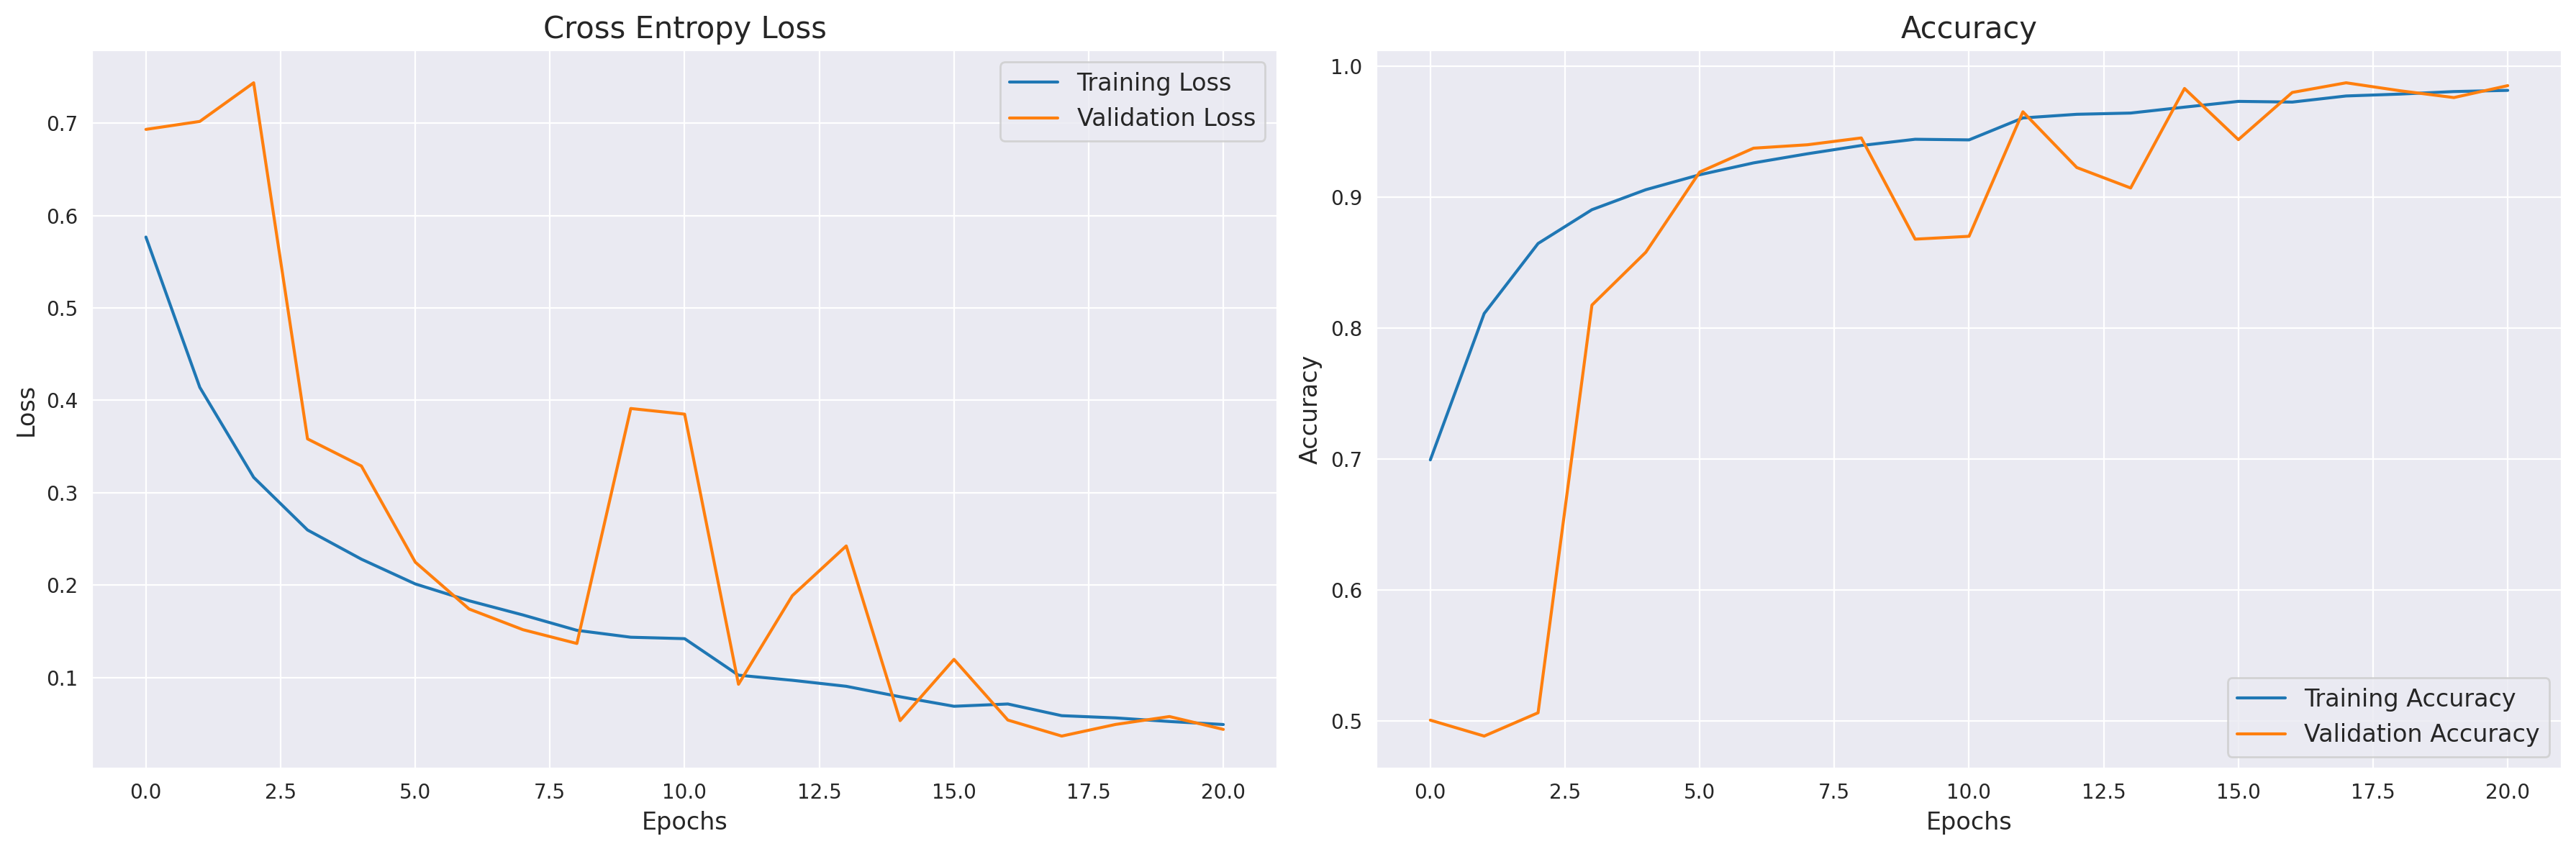

In [ ]:
error = pd.DataFrame(cat_n_dog.history)

plt.figure(figsize=(18,6),dpi=200)
sns.set_style('darkgrid')

plt.subplot(121)
plt.title('Cross Entropy Loss',fontsize=15)
plt.xlabel('Epochs', fontsize=12)
plt.ylabel('Loss', fontsize=12)
plt.plot(error['loss'], label='Training Loss')
plt.plot(error['val_loss'], label='Validation Loss')
plt.legend(loc='upper right', fontsize=12)

plt.subplot(122)
plt.title('Accuracy', fontsize=15)
plt.xlabel('Epochs', fontsize=12)
plt.ylabel('Accuracy', fontsize=12)
plt.plot(error['acc'], label='Training Accuracy')
plt.plot(error['val_acc'], label='Validation Accuracy')
plt.legend(loc='lower right', fontsize=12)

plt.tight_layout()
plt.show()

In [ ]:
# Save model
model.save('/content/cat_n_dog.keras')

# Evaluation

In [ ]:
model = tf.keras.models.load_model('/content/cat_vs_dog.keras')
model.compile(
    optimizer='adam',
    loss=keras.losses.BinaryCrossentropy(from_logits=False),
    metrics=[keras.metrics.BinaryAccuracy(name="acc")]
)

In [ ]:
def evaluate_model(model, dataset, dataset_name, batch_size):
    loss, acc = model.evaluate(dataset, batch_size=batch_size, verbose=0)
    print(f'Evaluation on {dataset_name} dataset:')
    print(f'- Accuracy: {acc * 100:.2f}%')
    print(f'- Loss: {loss:.4f}\n')

# Evaluate for train, validation, and test datasets
evaluate_model(model, train_dataset, 'training', batch_size)
evaluate_model(model, validation_dataset, 'validation', batch_size)
evaluate_model(model, test_dataset, 'test', batch_size)

Evaluation on training dataset:
- Accuracy: 97.18%
- Loss: 0.0783

Evaluation on validation dataset:
- Accuracy: 97.31%
- Loss: 0.0717

Evaluation on test dataset:
- Accuracy: 96.96%
- Loss: 0.0685



In [ ]:
true_labels = []
pred_labels = []

for batch_images, batch_labels in test_dataset:
    predictions = model.predict(batch_images, verbose=0)
    scores = predictions.flatten()

    # Classify as 1 (dog) if score > 0.5, else 0 (cat)
    batch_pred_labels = [1 if score > 0.5 else 0 for score in scores]

    true_labels.extend(batch_labels.numpy())
    pred_labels.extend(batch_pred_labels)

true_labels = np.array(true_labels)
pred_labels = np.array(pred_labels)

# Generate the classification report
report = classification_report(true_labels, pred_labels, target_names=["Cat", "Dog"])
print(report)

              precision    recall  f1-score   support

         Cat       0.97      0.98      0.98      1235
         Dog       0.98      0.97      0.98      1197

    accuracy                           0.98      2432
   macro avg       0.98      0.98      0.98      2432
weighted avg       0.98      0.98      0.98      2432



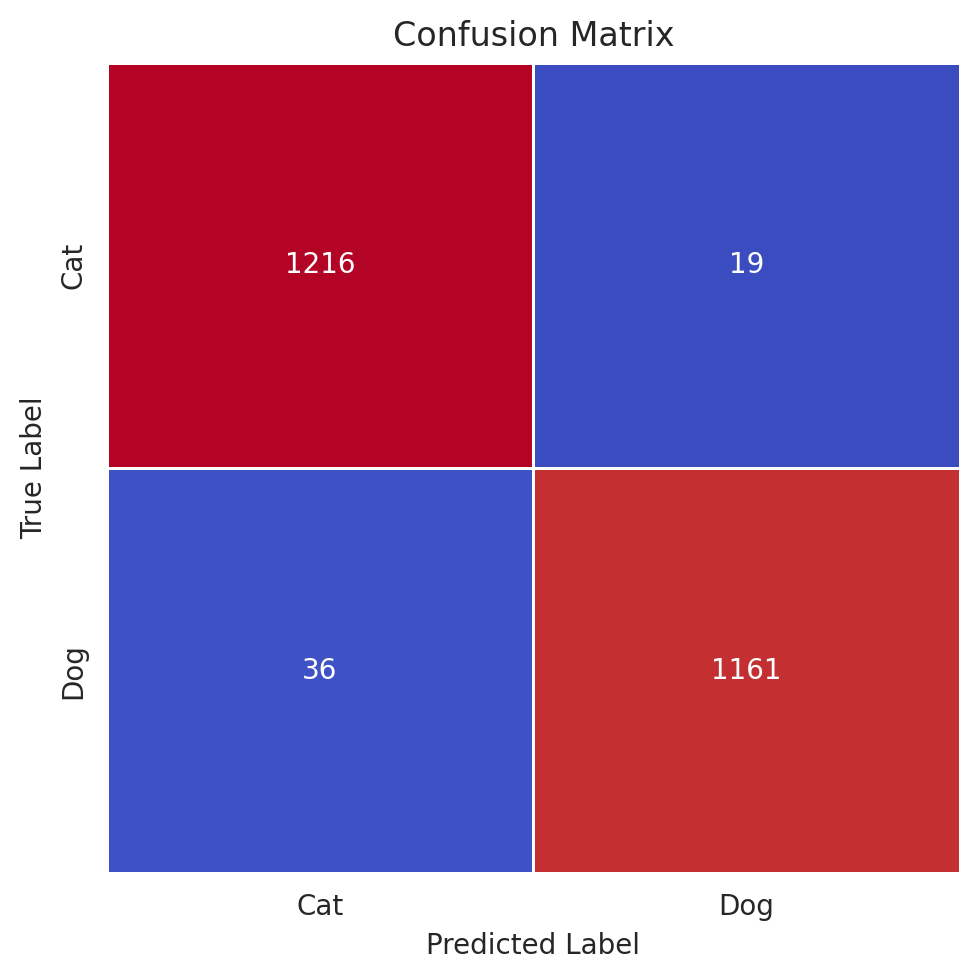

In [ ]:
# Generate the confusion matrix
confusion_mtx = confusion_matrix(true_labels, pred_labels)

# Create the heatmap
plt.figure(figsize=(5, 5), dpi=200)
sns.heatmap(confusion_mtx, annot=True, cmap="coolwarm", fmt='.0f', linewidths=1, linecolor="white",
            xticklabels=["Cat", "Dog"], yticklabels=["Cat", "Dog"], cbar=False)

plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")

# Show the plot
plt.tight_layout()
plt.show()
